# REINFORCE
This works, but I'm a little dissatisfied that we have to use `experimental_run_tf_function=False` to work correctly in TF2.0.

In [13]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(42)

In [14]:
# Instantiate environment
env = gym.make("CartPole-v1")

observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [20]:
def build_policy_network(input_size, output_size):
    inputs = tf.keras.layers.Input(input_size, name='input')
    advantages = tf.keras.layers.Input([1], name='advantages')
    dense1 = tf.keras.layers.Dense(32, activation='relu', name='hidden')(inputs)
    outputs = tf.keras.layers.Dense(output_size, activation='softmax', name='prob_outputs')(dense1)
    
    def custom_loss(y_true, y_pred):
        out = tf.clip_by_value(y_pred, 1e-8, 1-1e-8)
        log_like = y_true*tf.math.log(out)
        return - tf.reduce_sum(log_like * advantages)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    policy_model = tf.keras.Model(inputs=[inputs, advantages], outputs=outputs)
    policy_model.compile(loss=custom_loss, optimizer=tf.keras.optimizers.Adam(lr=1e-3), experimental_run_tf_function=False)
    
    return model, policy_model

In [21]:
def discount_rewards(rewards, discount_rate=0.99, normalize_rewards=False):
    rewards_to_go = list()
    cumulative_rewards = 0.0

    for r in rewards[::-1]:
        cumulative_rewards = r + discount_rate * cumulative_rewards
        rewards_to_go.append(cumulative_rewards)
    rewards_to_go.reverse()

    if normalize_rewards:
        mean = np.mean(rewards_to_go)
        std = np.std(rewards_to_go)
        rewards_to_go = (rewards_to_go - mean) / std
    return np.array(rewards_to_go)

In [22]:
def get_action(model, state):
    state = state.reshape((1, -1))
    action_prob = model.predict(state, batch_size=1).flatten()
    selected_action = np.random.choice(action_dim, 1, p=action_prob)[0]
    
    return selected_action

In [33]:
def update_policy(policy_model, rewards, states, actions):
    rewards_to_go = discount_rewards(rewards)
    states = np.vstack(states)
    actions_ = np.array(actions)
    actions = np.zeros([len(actions_), action_dim])
    actions[np.arange(len(actions_)), actions_] = 1
    
    loss = policy_model.train_on_batch(x={'input': states, 'advantages': rewards_to_go}, y=actions)

In [34]:
NUM_EPISODES = 650

predict_model, policy_model = build_policy_network(observation_dim, action_dim)

episode_rewards = list()
for episode in range(NUM_EPISODES):
    batch_rewards = []
    batch_obs = []
    batch_actions = []
    obs = env.reset()
    
    # Run policy to get one entire trajectory
    while True:
#         env.render()

        action = get_action(predict_model, obs)
        new_obs, reward, done, _ = env.step(action)

        # Save data
        batch_obs.append(obs)
        batch_rewards.append(reward)
        batch_actions.append(action)

        if done:
            episode_reward = sum(batch_rewards)
            episode_rewards.append(episode_reward)

            update_policy(policy_model, batch_rewards, batch_obs, batch_actions)

            print(f"Episode: {episode}, Reward: {episode_reward}")
            break

        obs = new_obs

Episode: 0, Reward: 18.0
Episode: 1, Reward: 16.0
Episode: 2, Reward: 11.0
Episode: 3, Reward: 16.0
Episode: 4, Reward: 36.0
Episode: 5, Reward: 28.0
Episode: 6, Reward: 14.0
Episode: 7, Reward: 31.0
Episode: 8, Reward: 12.0
Episode: 9, Reward: 28.0
Episode: 10, Reward: 12.0
Episode: 11, Reward: 36.0
Episode: 12, Reward: 15.0
Episode: 13, Reward: 12.0
Episode: 14, Reward: 28.0
Episode: 15, Reward: 12.0
Episode: 16, Reward: 11.0
Episode: 17, Reward: 14.0
Episode: 18, Reward: 26.0
Episode: 19, Reward: 32.0
Episode: 20, Reward: 10.0
Episode: 21, Reward: 19.0
Episode: 22, Reward: 19.0
Episode: 23, Reward: 19.0
Episode: 24, Reward: 15.0
Episode: 25, Reward: 21.0
Episode: 26, Reward: 36.0
Episode: 27, Reward: 10.0
Episode: 28, Reward: 26.0
Episode: 29, Reward: 31.0
Episode: 30, Reward: 16.0
Episode: 31, Reward: 16.0
Episode: 32, Reward: 14.0
Episode: 33, Reward: 21.0
Episode: 34, Reward: 15.0
Episode: 35, Reward: 15.0
Episode: 36, Reward: 12.0
Episode: 37, Reward: 39.0
Episode: 38, Reward: 1

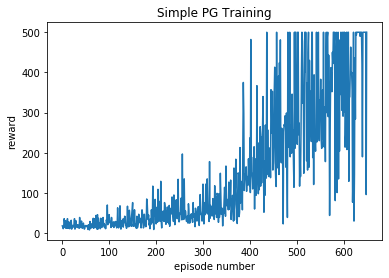

In [35]:
plt.plot([i for i in range(NUM_EPISODES)], episode_rewards)
plt.xlabel("episode number")
plt.ylabel("reward")
plt.title("Simple PG Training")
plt.show()